In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

PATH = os.path.abspath('..')

seed = 12345

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


# Train

In [25]:
%run -i {PATH}/src/train_alfalfa.py --lr=10e-2 --bs=32 --n_epochs=100 --model=mxresnet50 \
    --seed={seed} --precision=full --catalog=fgas --save="best_a40A-50"

Loaded `fgas` catalog of length 7399


epoch,train_loss,valid_loss,time
0,0.368326,0.495954,00:50
1,0.323070,0.387891,00:50
2,0.306426,0.355779,00:50
3,0.304352,0.317721,00:50
4,0.296395,0.361922,00:50
5,0.314475,0.290066,00:50
6,0.296707,0.359960,00:50
7,0.329407,0.317499,00:50
8,0.323712,0.792963,00:50
9,0.312850,0.350604,00:50


<Figure size 432x288 with 0 Axes>

The best model is saved in `{PATH}/models/best_a40.pth`, unless another filename has been specified.

## Experimental results
    
    Results (all_properties = False; 7399)
                                           Val loss    TTA loss
      n_epoch  max_lr  precision   arch    --------    --------
        100     3e-2     mixed      34       0.240       0.246 
        100     3e-2     full       34       0.242       0.250
         40     3e-2     full       34       0.241       0.248
         
        100     3e-2     full       50       0.242       0.248
        
        
    Results (all_properties = True; 4797)
    
         40     5e-2     full       34       0.241       0.249
         40     3e-2     full       34       0.239       0.245
         40     1e-2     full       34       0.242       0.250
         40     3e-2     full       50       0.240       0.246

        

Note: mixed precision is great on NVidia T4 cards (available on Colab), but it's actually slower than 32-bit floats when using P100s!


    Training + validation time per epoch (`fgas` catalog)
    
                       P100 `fgas` `all`
                       ==== ------ -----
    Mixed precision          0:51   0:31
    Full precision           0:50   0:29

# Evaluate

In [7]:
# learn.to_fp32();

In [21]:
learn.load('best_a40B-50');

set state called


In [26]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2513)

# Plot

In [27]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)


results.to_csv(f'{PATH}/results/predictions/best_a40A-50.csv')

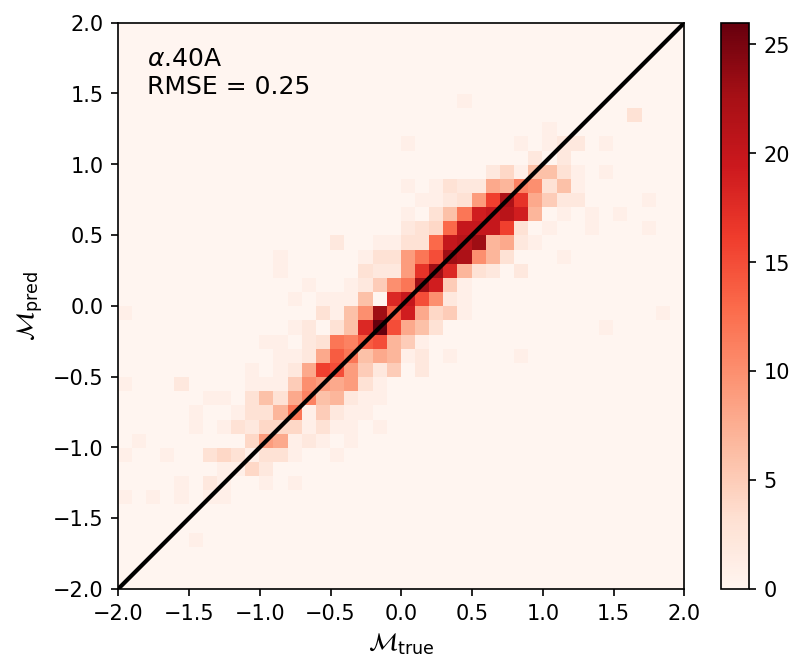

In [24]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(results.fgas_true, results.fgas_pred, cmap='Reds', range=[(-2, 2), (-2, 2)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)
plt.gca().set_aspect('equal')
plt.colorbar();
plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2.5, .5))
plt.yticks(np.arange(-2, 2.5, .5));

rmse_results = root_mean_squared_error(fgas_pred, fgas_true)

plt.text(-1.8, 1.5, r'$\alpha$.40A' +'\n' + f'RMSE = {rmse_results:.2f}', fontsize=12);
catalog_id = "A"
plt.savefig(f'{PATH}/results/figures/results-hist_a40{catalog_id}')